The aim of this notebook is to perform a quick test for an update of the model or a new optimization procedure.
To test a model update, each cell of this notebook must run with correct results.
To test a new optimization procedure, a new dedicated cell must be created on the same model as the previous ones.

As this pipeline consist in only one instance solved by each procedure once, it statisticaly has no meaning. For a statisticaly meaningful test pipeline, please run the Test pipeline notebook (heavily time consuming). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
import json

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import normalize_scale

Error: IPOPT shared library failed to import


Generate the theoritical organoïd

In [2]:
theta = 0.02

def get_sequence(seed):
    np.random.seed(seed)
    
    return np.random.randint(10, size=10)

In [3]:
with open('../assets/benchmark_instances/list_seed.json',
          'r') as inputfile:
    LIST_SEED = json.load(inputfile)['list']
seed = 1678

In [4]:
draw = generate_ring(5,0.5,1.0)# Model parameters or specifications
geom.update_all(draw)
normalize_scale(draw, geom)
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  1.0, 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

draw.update_specs(specs, reset=True)

def plot_meca(exp_organo):
    draw_specs = sheet_spec()
    draw_specs['edge']['visible'] = True
    draw_specs['vert']['visible'] = False
    edge_color = np.linspace(0.1, 0.1, 
                        num=draw.edge_df.shape[0])
    edge_color[0] = 1.0
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['edge']['color'] = edge_cmap
    fig = plt.figure(1)
    fig, ax = sheet_view(draw, ['x', 'y'], **draw_specs)
    draw.vert_df.loc[0, ['x', 'y']] = [0.4,-0.6]
    draw.vert_df.loc[1, ['x', 'y']] = [-0.1,-0.75]
    geom.update_all(draw)
    fig, ax = sheet_view(draw, ['x', 'y'], **draw_specs)
    pass
plot_meca(draw)

NameError: name 'organo' is not defined

In [5]:
organo = generate_ring(10, 110, 150)
Nf= organo.Nf
geom.update_all(organo)
normalize_scale(organo, geom)
print(organo.settings)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  list(alpha*organo.face_df.area.values), 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)

symetric_tensions = set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)
sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf, endpoint=False)))**2
organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
organo.edge_df.line_tension = prepare_tensions(organo, symetric_tensions)
organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

new_tensions = organo.edge_df.line_tension

organo.edge_df.loc[:,'line_tension'] = new_tensions

res = Solver.find_energy_min(organo, geom, model)  

#save_datasets('/home/fquinton/Documents/Stage_M2_ICA-master/tyssue-taylor/assets/benchmark_instances/pipeline_test_theoritical_organo'+str(seed)+'.hdf5', 
#              organo)
dic_json = specs
dic_json['seed'] = seed
dic_json['theta'] = theta
print(dic_json)
#with open('/home/fquinton/Documents/Stage_M2_ICA-master/tyssue-taylor/assets/benchmark_instances/pipeline_test_theoritical_organo_specs'+str(seed)+'.json', 'w+') as outfile:
#    json.dump(dic_json, outfile)

Reseting datasets values with new specs


{'R_in': 1.9896728355976676, 'R_out': 2.713190230360456, 'R_vit': None, 'lumen_volume': 23.269230769230774}
{'face': {'is_alive': 1, 'prefered_area': [1.069106838843029, 1.069106838843029, 1.0691068388430292, 1.0691068388430292, 1.0691068388430287, 1.0691068388430285, 1.0691068388430292, 1.0691068388430292, 1.0691068388430285, 1.0691068388430287], 'area_elasticity': 1.0}, 'edge': {'ux': 0.0, 'uy': 0.0, 'uz': 0.0, 'line_tension': 0.1, 'is_active': 1}, 'vert': {'adhesion_strength': 0.0, 'x_ecm': 0.0, 'y_ecm': 0.0, 'is_active': 1}, 'settings': {'lumen_elasticity': 0.1, 'lumen_prefered_vol': 23.269230769230774, 'lumen_volume': 23.269230769230774}, 'seed': 1678, 'theta': 0.02}


In [6]:
from tyssue_taylor import version
version.git_revision

'f1eaddbebaee5bee74a16a009005e9af1d2236b8'

Creating a printing function

In [7]:
def get_sequence(seed, theta, shape):
    np.random.seed(seed)
    
    return np.random.normal(1.0, theta, shape)

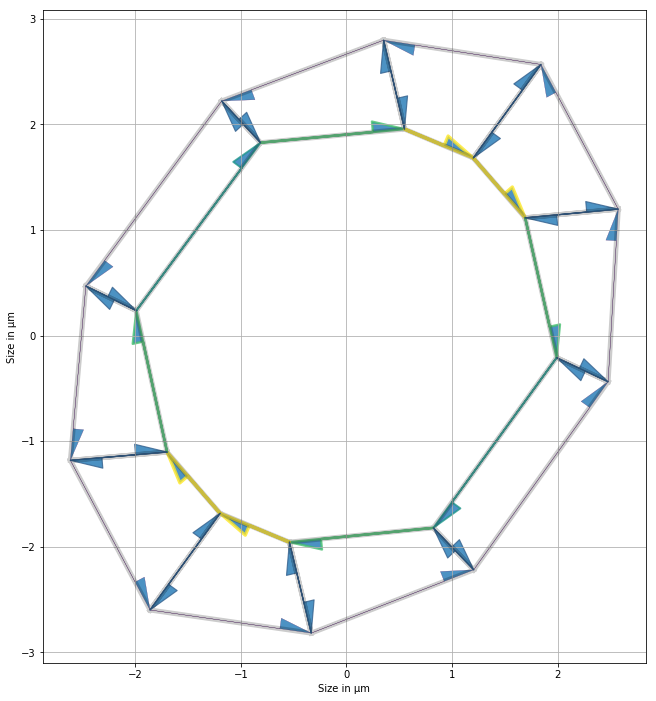

In [8]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()

    edge_color = np.array([1/max(exp_organo.edge_df.line_tension)*l for l in exp_organo.edge_df.line_tension])

    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap #[0, 0, 0, 1]
    #draw_specs['edge']['color'] = [0, 0, 0, 0.2]

    draw_specs['edge']['width'] = 0.25+3*np.array([1/max(exp_organo.edge_df.line_tension)*l for l in exp_organo.edge_df.line_tension])
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)

    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')
    plt.show()
    pass

print_tensions(organo, organo)

(<matplotlib.figure.Figure at 0x7f9c72048b38>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9c6cc8aeb8>)

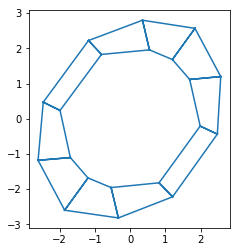

In [9]:
quick_edge_draw(organo)

Define the optimization parameters

In [10]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-4}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-4, 'disp': 1}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-2,'ftol': 1e-2, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-6,'ftol': 1e-5, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'PSQP'}

reg_weight = 1e-3

## SLSQP energy minimization
This minimization procedure uses Sequenitial Least Squares Sequential Quadratic Programming (SLSQP) procedure from scopy to find the set of linear tensions that minimizes the energy in the experimental organoïd under constraint that 
$$||X_e-X_t||<\epsilon $$
Where $X_e$ (resp. $X_t$) is the set of euclidian coordinates of the vertices of the experimental (resp. theoritical) organoïd, and $\epsilon$ is the maximum distance allowed between the two. 
Initial point is computed with lm procedure.

It can be implemented with or without a regulzarization module that regularize the linear tensions of the apical or basal edges. 
It can be implemented with or without the lumen volume as an optimization parameter.

In [11]:
from tyssue_taylor.adjusters.cost_functions import _distance as dist
initial_guess = set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

Energy before optimization:  1.2561308499090231
Starting the search for the initial point
`xtol` termination condition is satisfied.
Function evaluations 7076, initial cost 3.8588e+00, final cost 1.1120e-02, first-order optimality 2.16e-01.
Initial point found with distance 0.054698684086737524
                    Starting the energy minimization.
[0.00000000e+00 4.16333634e-16 1.47104551e-15 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.47564635e-02 0.00000000e+00 0.00000000e+00 2.29489321e-02
 1.61469955e-02 2.32371353e-02 0.00000000e+00 0.00000000e+00
 9.67228482e-04 5.44193175e-03 6.59953733e-03 7.38992201e-16
 1.26981758e-15 0.00000000e+00 1.65589361e-02 3.53687000e-02
 3.25210870e-02 0.00000000e+00 0.00000000e+00 3.57350450e-02
 5.22523851e-02 5.94664835e-02]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10. 10. 10.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.  0.  0.  0. 10. 10. 10.

/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


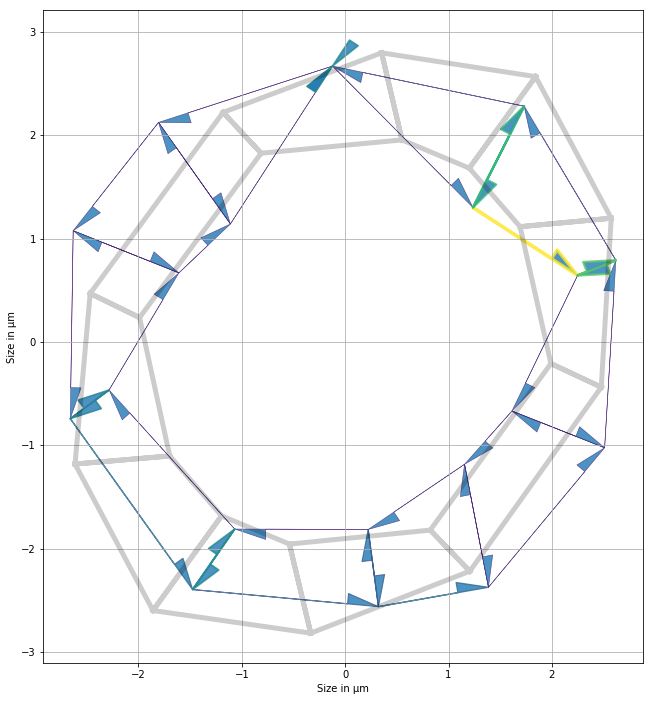

In [14]:
slsqp_opt = {'method': 'SLSQP','options': {'ftol':1e-4}}
start = time.clock()
noisy_psqp_nr_nl = organo.copy()
print('Energy before optimization: ', model.compute_energy(noisy_psqp_nr_nl, False))
res = adjust_tensions(noisy_psqp_nr_nl, initial_guess, {'dic':{}, 'weight':0.001},
                      energy_opt, lm_opt, **slsqp_opt)
noisy_psqp_nr_nl.edge_df.line_tension = prepare_tensions(noisy_psqp_nr_nl,res.x)
Solver.find_energy_min(noisy_psqp_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(noisy_psqp_nr_nl, False))
print('Final distance: ', dist(noisy_psqp_nr_nl, organo))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_psqp_nr_nl, organo)

In [15]:
res

     fun: 0.4795081298971068
     jac: array([ -19079.19767732,  -22604.48791902,  -26720.44401132,
        -49009.74949086,  -60448.12302453,  107338.51192342,
        -76632.51926437,   61432.9662693 ,   -7544.93645476,
        117836.03250187,   64651.38105449, -153850.82023003,
         76854.427165  ,   68612.41623558, -213285.71200337,
         71407.7183506 ,  -91049.16149997,  -78212.27931829,
         67677.41976757,   83459.14469776,   65280.59062632,
         70201.91837018,   77424.63287672,   91679.39369383,
         73834.23091527,  -50085.49834961,  -97776.56382411,
        -60014.25394996,   66171.98119379,   67067.50490695])
 message: 'Positive directional derivative for linesearch'
    nfev: 148
     nit: 8
    njev: 4
  status: 8
 success: False
       x: array([0.0097648 , 0.0097648 , 0.0097648 , 0.0097648 , 0.0097648 ,
       0.0097648 , 0.0097648 , 0.0097648 , 0.09435582, 0.0097648 ,
       0.0097648 , 0.03266015, 0.02587149, 0.03294779, 0.0097648 ,
       0.00976

1.1624812017472297 -0.02256453114036023 0.9057869469308878


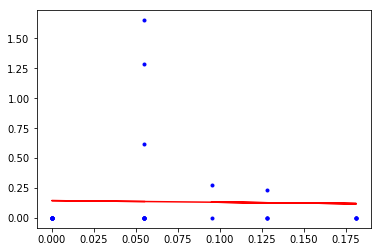

In [17]:
from scipy import stats

var_tens = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res['x']),
                     np.full(res['x'].shape, organo.edge_df.line_tension[:3*organo.Nf].mean()))

slope, intercept, r_value, p_value, std_err = stats.linregress(organo.edge_df.line_tension.values[:3*Nf] ,res['x'])
print(std_err, r_value, p_value)
plt.plot(organo.edge_df.line_tension.values[:3*Nf],res['x'], 'b.')
plt.plot(organo.edge_df.line_tension.values[:3*Nf], intercept+slope*organo.edge_df.line_tension.values[:3*Nf],
        'r-')

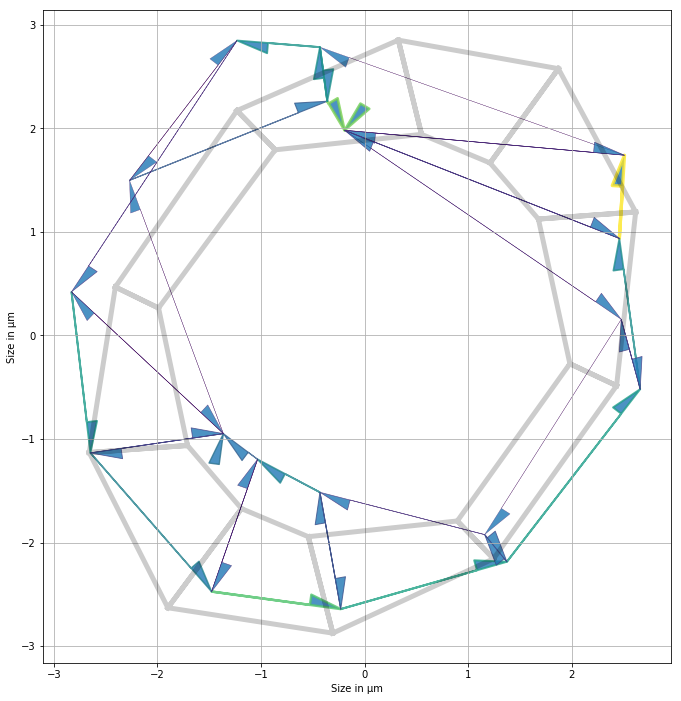

In [20]:
essai = [0. ,        0.00684982 ,0.02571819, 0.01625484, 0.02070792, 0.0008716,
 0.01526554, 0.04393318, 0.04292508, 0.00418147 ,0.03058589, 0.03179668,
 0.03958807, 0.02432023, 0.0299821,  0.00635164, 0.02854197, 0.,
 0.05490804, 0.027131,   0.00887298, 0.01165079 ,0.01319709, 0.00440921,
 0.0101428,  0.0020483,  0.,         0.02808412, 0.00517731, 0.00785975 ]
noisy_psqp_nr_nl.edge_df.line_tension = prepare_tensions(noisy_psqp_nr_nl,essai)
Solver.find_energy_min(noisy_psqp_nr_nl, geom, model)
print_tensions(noisy_psqp_nr_nl, organo)

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
noisy_psqp_r_nl = noisy.copy()
res = adjust_tensions(noisy_psqp_r_nl, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, lm_opt, **psqp_opt)
noisy_psqp_r_nl.edge_df.line_tension = prepare_tensions(noisy_psqp_r_nl,res.x)
Solver.find_energy_min(noisy_psqp_r_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_psqp_r_nl)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
noisy_psqp_nr_l = noisy.copy()
res = adjust_tensions(noisy_psqp_nr_l, np.concatenate((initial_guess[:3*organo.Nf], [organo.settings['lumen_volume']])), 
                      {'dic':{}, 'weight':0}, energy_opt, lm_opt, **psqp_opt)
noisy_psqp_nr_l.edge_df.line_tension = prepare_tensions(noisy_psqp_nr_l,res.x[:3*organo.Nf])
Solver.find_energy_min(noisy_psqp_nr_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_psqp_nr_l)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [17]:
start = time.clock()
noisy_psqp_r_l = noisy.copy()
res = adjust_tensions(noisy_psqp_r_l, np.concatenate((initial_guess[:3*organo.Nf], [organo.settings['lumen_volume']])),
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, lm_opt, **psqp_opt) 
noisy_psqp_r_l.edge_df.line_tension = prepare_tensions(noisy_psqp_r_l,res.x[:3*organo.Nf])
Solver.find_energy_min(noisy_psqp_r_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_psqp_r_l)

NameError: name 'noisy' is not defined

# Stability to the initial guess

We will now test the behavior of the solution of our optimization processes wrt the distance from the optimum to the initial guess. We will work directly on the theoritical mesh and apply higher and higher noise to the real values to obtain the initial  guess.

In [15]:
theta_ig = 0.2
initial_guess = organo.edge_df.line_tension.values[:3*organo.Nf] * np.random.normal(1.0, theta_ig, 3*organo.Nf)

## LM distance minimization
This minimization procedure uses Levenberg-Marquardt (lm) procedure from scipy.least_squares to find the set of linear tensions that minimize the euclidian distance from the theoritical organoid to the experimental organoid. Extensive description can be found above.

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.8243e-01                                    1.57e+04    
       1              3         3.4799e-01      3.44e-02       2.04e-03       8.34e+03    
`xtol` termination condition is satisfied.
Function evaluations 3, initial cost 3.8243e-01, final cost 3.4799e-01, first-order optimality 8.34e+03.
Solving time: 66.904829
Tension error: [2.49878792e-07 5.21650986e-03 1.49746170e-03 1.81265580e-09
 2.20126058e-07 1.72265193e-03 2.82245466e-04 4.17572671e-07
 1.14144838e-07 1.63959790e-07            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
 2.46381644e-02 1.10197880e-06 9.15174410e-08 7.07482494e-07
 1.16153427e-02 1.54271169e-07 5.31397918e-04 1.59688184e-07
 1.84000631e-02 9.01442452e-07]
res:   active_mask: array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1

/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


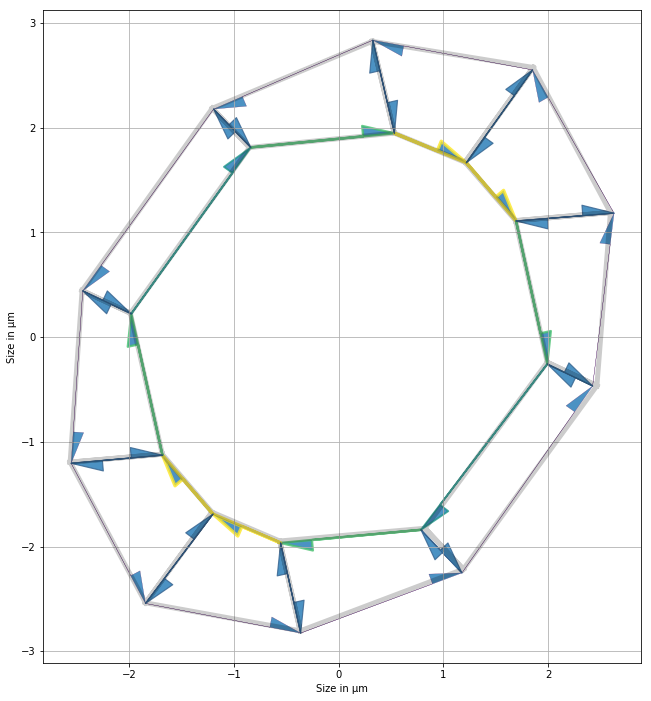

In [72]:
start = time.clock()
noisy_trf_nr_nl = noisy.copy()
res = adjust_tensions(noisy_trf_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, **trf_opt) 
noisy_trf_nr_nl.edge_df.line_tension = prepare_tensions(noisy_trf_nr_nl, res.x)
Solver.find_energy_min(noisy_trf_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
error = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)
print('Tension error: '+str(error))
print('res: ', res)
print_tensions(noisy_trf_nr_nl, organo)

In [35]:
error = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)
print(error)

[1.63948446e-07 5.61470612e-03 1.34110823e-03 1.00379240e-08
 2.36983138e-07 9.79916014e-04 2.60104128e-04 2.63507873e-07
 1.39710008e-07 3.15485169e-07            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
 2.55587216e-02 1.24868740e-06 4.47118477e-04 7.83884964e-07
 1.40665493e-02 1.96289132e-07 1.76607738e-03 5.01060957e-09
 1.57879666e-02 7.82374953e-07]


/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


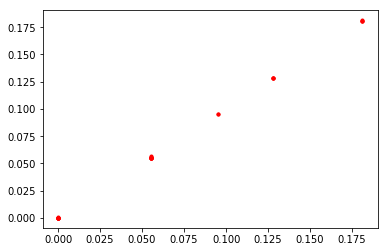

In [33]:
import matplotlib.pyplot as plt
plt.plot(organo.edge_df.line_tension.values[:3*Nf], res.x, 'r.')

In [73]:
real_tensions = organo.edge_df.line_tension[:3*Nf].copy().values
real_tensions[:Nf] += 1 - real_tensions[:Nf].mean()
real_tensions[Nf:2*Nf] += 1 - real_tensions[Nf:2*Nf].mean()
real_tensions[2*Nf:3*Nf] += 1 - real_tensions[2*Nf:3*Nf].mean()

resx = res.x.copy()
resx[:Nf] += 1 - resx[:Nf].mean()
resx[Nf:2*Nf] += 1 - resx[Nf:2*Nf].mean()
resx[2*Nf:3*Nf] += 1 - resx[2*Nf:3*Nf].mean()



[0.95244717 0.98530537 1.03847104 1.03847104 0.98530537 0.95244717
 0.98530537 1.03847104 1.03847104 0.98530537 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ] [0.9523333  0.98585904 1.03862842 1.03835719 0.98519149 0.95249715
 0.98522763 1.03835711 1.03835717 0.98519149 0.99988149 1.0002951
 1.00004831 1.00001798 0.99988149 1.0002001  0.99988149 0.99988149
 1.00003105 0.99988149 1.0010536  0.99969586 0.99969591 0.99969588
 1.00033598 0.99969591 0.9997252  0.99969593 1.00070985 0.99969587]


In [76]:
print(real_tensions, resx)

[0.95244717 0.98530537 1.03847104 1.03847104 0.98530537 0.95244717
 0.98530537 1.03847104 1.03847104 0.98530537 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ] [0.9523333  0.98585904 1.03862842 1.03835719 0.98519149 0.95249715
 0.98522763 1.03835711 1.03835717 0.98519149 0.99988149 1.0002951
 1.00004831 1.00001798 0.99988149 1.0002001  0.99988149 0.99988149
 1.00003105 0.99988149 1.0010536  0.99969586 0.99969591 0.99969588
 1.00033598 0.99969591 0.9997252  0.99969593 1.00070985 0.99969587]


In [77]:
print(np.divide(resx, real_tensions))

[0.99988044 1.00056193 1.00015155 0.99989036 0.99988442 1.00005248
 0.9999211  0.99989029 0.99989034 0.99988443 0.99988149 1.0002951
 1.00004831 1.00001798 0.99988149 1.0002001  0.99988149 0.99988149
 1.00003105 0.99988149 1.0010536  0.99969586 0.99969591 0.99969588
 1.00033598 0.99969591 0.9997252  0.99969593 1.00070985 0.99969587]


In [69]:
organo.edge_df[:3*Nf]

,dy,dx,srce,face,length,nz,trgt,segment,prev,sub_area,ux,uy,uz,line_tension,is_active
edge,,,,,,,,,,,,,,,
0,-1.585794,-1.167443,0,0,1.969179,0.512787,1,apical,20,0.256394,-0.592858,-0.805307,0.0,0.095106,1
1,-0.121635,-1.387318,1,1,1.392640,0.450318,2,apical,21,0.225159,-0.996178,-0.087341,0.0,0.127964,1
2,0.275684,-0.647222,2,2,0.703490,0.309252,3,apical,22,0.154626,-0.920016,0.391881,0.0,0.181130,1
3,0.553484,-0.474177,3,3,0.728827,0.321382,4,apical,23,0.160691,-0.650603,0.759418,0.0,0.181130,1
4,1.346204,-0.304835,4,4,1.380286,0.440726,5,apical,24,0.220363,-0.220849,0.975308,0.0,0.127964,1
5,1.582698,1.137475,5,5,1.949046,0.491162,6,apical,25,0.245581,0.583606,0.812037,0.0,0.095106,1
6,0.137592,1.382963,6,6,1.389791,0.452095,7,apical,26,0.226047,0.995087,0.099002,0.0,0.127964,1
7,-0.278344,0.674524,7,7,0.729697,0.331153,8,apical,27,0.165577,0.924389,-0.381451,0.0,0.181130,1
8,-0.558096,0.483970,8,8,0.738714,0.336239,9,apical,28,0.168120,0.655152,-0.755497,0.0,0.181130,1


In [41]:
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values.values)))

AttributeError: 'numpy.ndarray' object has no attribute 'values'

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
reg_weight = 1e-3

res = adjust_tensions(noisy, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **trf_opt)
noisy_r_nl = noisy.copy()
noisy_r_nl.edge_df.line_tension = prepare_tensions(noisy_r_nl, res.x)
Solver.find_energy_min(noisy_r_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_r_nl, organo)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
trf_opt = {'bounds': ([0]*(3*organo.Nf+1),[1000]*(3*organo.Nf)+[1e6]), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-1, 'verbose': 2}
start = time.clock()
res = adjust_tensions(noisy, np.concatenate((initial_guess[:3*organo.Nf], [organo.settings['lumen_volume']])), 
                      {'dic':{}, 'weight':0}, energy_opt, **trf_opt)
noisy_nr_l = noisy.copy()
noisy_nr_l.edge_df.line_tension = prepare_tensions(noisy_nr_l, res.x)
Solver.find_energy_min(noisy_nr_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_nr_l, organo)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
trf_opt = {'bounds': ([0]*(3*organo.Nf+1),[1000]*(3*organo.Nf)+[1e6]), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-1, 'verbose': 2}
start = time.clock()
res = adjust_tensions(noisy, np.concatenate((initial_guess[:3*organo.Nf], [organo.settings['lumen_volume']])),
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **trf_opt)
noisy_r_l = noisy.copy()
noisy_r_l.edge_df.line_tension = prepare_tensions(noisy_r_l,res.x[:3*organo.Nf])
Solver.find_energy_min(noisy_r_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_r_l, organo)

In [ ]:
start = time.clock()
copy_lm_nr_nl = organo.copy()
res = adjust_tensions(copy_lm_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, **lm_opt)
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl,res.x)
Solver.find_energy_min(noisy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_lm_r_nl = organo.copy()
res = adjust_tensions(copy_lm_r_nl, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **lm_opt)
copy_lm_r_nl.edge_df.line_tension = prepare_tensions(copy_lm_r_nl,res.x)
Solver.find_energy_min(copy_lm_r_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_r_nl, organo)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_lm_nr_l = organo.copy()
res = adjust_tensions(copy_lm_nr_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])), 
                      {'dic':{}, 'weight':0}, energy_opt, **lm_opt)
copy_lm_nr_l.edge_df.line_tension = prepare_tensions(copy_lm_nr_l,res.x)
Solver.find_energy_min(copy_lm_nr_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_l, organo)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_lm_r_l = organo.copy()
res = adjust_tensions(copy_lm_r_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])),
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **lm_opt)
copy_lm_r_l.edge_df.line_tension = prepare_tensions(copy_lm_r_l,res.x)
Solver.find_energy_min(copy_lm_r_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_r_l, organo)

## TRF distance minimization
This minimization procedure uses Trust Region Function (trf) procedure from scipy.least_squares to find the set of linear tensions that minimize the euclidian distance from the theoritical organoid to the experimental organoid. 
It can be implemented with or without a regulzarization module that regularize the linear tensions of the apical or basal edges. 
It can be implemented with or without the lumen volume as an optimization parameter.

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_trf_nr_nl = organo.copy()
res = adjust_tensions(copy_trf_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, **trf_opt) 
copy_trf_nr_nl.edge_df.line_tension = prepare_tensions(copy_trf_nr_nl, res.x)
Solver.find_energy_min(copy_trf_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_trf_nr_nl, organo)

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_trf_r_nl = organo.copy()
res = adjust_tensions(copy_trf_r_nl, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **trf_opt)
copy_trf_r_nl.edge_df.line_tension = prepare_tensions(copy_trf_r_nl, res.x)
Solver.find_energy_min(copy_trf_r_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_trf_r_nl, organo)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
trf_opt = {'bounds': ([0]*(3*organo.Nf+1),[1000]*(3*organo.Nf)+[1e6]), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-1, 'verbose': 0}
start = time.clock()
copy_trf_nr_l = organo.copy()
res = adjust_tensions(copy_trf_nr_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])), 
                      {'dic':{}, 'weight':0}, energy_opt, **trf_opt)
copy_trf_nr_l.edge_df.line_tension = prepare_tensions(copy_trf_nr_l, res.x)
Solver.find_energy_min(copy_trf_nr_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_trf_nr_l, organo)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
trf_opt = {'bounds': ([0]*(3*organo.Nf+1),[100]*(3*organo.Nf)+[1e6]), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-1, 'verbose': 0}
start = time.clock()
copy_trf_r_l = copy.copy()
res = adjust_tensions(copy_trf_r_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])),
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **trf_opt)
copy_trf_r_l.edge_df.line_tension = prepare_tensions(copy_trf_r_l,res.x[:3*organo.Nf])
Solver.find_energy_min(copy_trf_r_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_trf_r_l)

## PSQP energy minimization
This minimization procedure uses Preconditionned Sequential Quadratic Programming (PSQP) procedure from pyOpt to find the set of linear tensions that minimizes the energy in the experimental organoïd under constraint that 
$$||X_e-X_t||<\epsilon $$
Where $X_e$ (resp. $X_t$) is the set of euclidian coordinates of the vertices of the experimental (resp. theoritical) organoïd, and $\epsilon$ is the maximum distance allowed between the two. 
Initial point is computed with lm procedure.

It can be implemented with or without a regulzarization module that regularize the linear tensions of the apical or basal edges. 
It can be implemented with or without the lumen volume as an optimization parameter.

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_psqp_nr_nl = organo.copy()
res = adjust_tensions(copy_psqp_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, lm_opt, **psqp_opt)
copy_psqp_nr_nl.edge_df.line_tension = prepare_tensions(copy_psqp_nr_nl,res.x)
Solver.find_energy_min(copy_psqp_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_psqp_nr_nl)

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_psqp_r_nl = organo.copy()
res = adjust_tensions(copy_psqp_r_nl, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, lm_opt, **psqp_opt)
copy_psqp_r_nl.edge_df.line_tension = prepare_tensions(copy_psqp_r_nl,res.x)
Solver.find_energy_min(copy_psqp_r_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_psqp_r_nl)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_psqp_nr_l = organo.copy()
res = adjust_tensions(copy_psqp_nr_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])),
                      {'dic':{}, 'weight':0},
                      energy_opt, lm_opt, **psqp_opt)
copy_psqp_nr_l.edge_df.line_tension = prepare_tensions(copy_psqp_nr_l,res.x[:3*organo.Nf])
Solver.find_energy_min(copy_psqp_nr_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_psqp_nr_l)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_psqp_r_l = organo.copy()
res = adjust_tensions(copy_psqp_r_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])),
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, lm_opt, **psqp_opt) 
copy_psqp_r_l.edge_df.line_tension = prepare_tensions(copy_psqp_r_l,res.x[:3*organo.Nf])
Solver.find_energy_min(copy_psqp_r_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_psqp_r_l)